<a href="https://colab.research.google.com/github/selamtigistu1/MachineLearning/blob/main/Sketch_to_Photo_ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Conv2D,Conv2DTranspose,LeakyReLU,Activation,Concatenate,Dropout,BatchNormalization
from keras.preprocessing.image import img_to_array,load_img,ImageDataGenerator,array_to_img
from numpy import asarray,savez_compressed,load,asarray,zeros,ones,vstack
import numpy as np
from numpy.random import randint
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow as tf, keras
from IPython import display
import os, os.path, shutil
from os import listdir
import pandas as pd
import natsort
import argparse
import glob
import cv2
import keras 
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model, load_model,Input
from keras.preprocessing.image import img_to_array,load_img
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.models import load_model
mae_loss = tf.keras.losses.MeanAbsoluteError()
mae_metrics = tf.keras.metrics.MeanAbsoluteError()



Mount Drive

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_dir_train = '/content/drive/MyDrive/dataset/dataset_project/train/'
data_dir_test = '/content/drive/MyDrive/dataset/dataset_project/test'
output_dir = '/content/drive/MyDrive/dataset/dataset_project/output' 
PATH='/content/drive/MyDrive/dataset/dataset_project/output/train_join/' 
target_size=(256,256)

In [ ]:
# #to join the train (sketch and photo) 
# src_list, tar_list,paired = list(), list(),list()
# i = 0
# path_s = os.path.join(data_dir_train , 'sketch')
# path_p = os.path.join(data_dir_train , 'photo')
# for img in os.listdir(path_s):
#     image_s = load_img(path_s + '/' + img, target_size)
#     src_list.append(image_s)
#     if (img[0] == 'F'):  
#       img = 'f' + img[2:9] + '.jpg'
#     elif (img[0] =='M'):
#       img= 'm' + img[2:9] + '.jpg'    
#     image_p = load_img(path_p + '/' + img, target_size)
#     tar_list.append(image_p)
#     paired.append(np.concatenate((image_s, image_p), axis=1))
#     plt.imsave(f"{PATH}/00{i}.jpg",paired[i])  
#     i+=1
# print(i)

88


In [ ]:
#6
#creating the directories of the augmented data

sketch_dir = output_dir +'/sketch-aug/'
photo_dir =  output_dir +'/photo-aug/'
from os import listdir

if not os.path.exists(sketch_dir):
    os.mkdir(sketch_dir)

if not os.path.exists(photo_dir):
    os.mkdir(photo_dir)

In [ ]:
#7
#creating the datagen function for data augmentation
datagen=ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
#increasing the dataset
p_filenames = sorted(glob.glob(data_dir_train +'/photo/*.jpg'))
s_filenames = sorted(glob.glob(data_dir_train +'/sketch/*.jpg'))
for j in range(len(p_filenames)):
    im = load_img( p_filenames[j])
    im = cv2.resize(np.float32(im), (256, 256), interpolation = cv2.INTER_AREA)
    im = im/255
    im=im.reshape((1,)+im.shape)
    i=0    
    k=0 
    for b in datagen.flow(im,batch_size=1 ,seed=123):
      imb = b[0,:,:]*255
      im = cv2.cvtColor(imb, cv2.COLOR_BGR2RGB)
      cv2.imwrite(photo_dir+"/%i%i.jpg"%(j,i),im) 
      i+=1
      if i>4:
        break      
    image = tf.io.read_file(s_filenames[j])
    target_size=(256,256)
    image = tf.image.decode_jpeg(image, channels=1)
    image=tf.image.resize(image, target_size)
    image=img_to_array(image)
    image= image/255
    image=image.reshape((1,)+image.shape)
    for b in datagen.flow(image,batch_size=1 ,seed=123):
      imb = b[0,:,:]*255
      cv2.imwrite(sketch_dir+"/%i%i.jpg"%(j,k),imb)
      k+=1
      if k>4:
        break    
print(j)

87


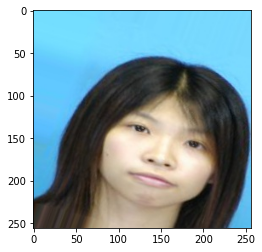

In [ ]:
#sample Augmented Photo
photo_im = sorted(glob.glob(output_dir +'/photo-aug/*.jpg'))
sketch_im = sorted(glob.glob(output_dir +'/sketch-aug/*.jpg'))
plt.imshow(cv2.cvtColor(cv2.imread(photo_im[00]).astype('uint8'), cv2.COLOR_BGR2RGB))

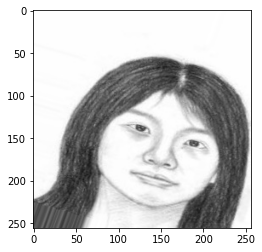

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(sketch_im[00]).astype('uint8'), cv2.COLOR_BGR2RGB))

In [ ]:
#to join the data augmented train (sketch and photo)
p_filenames = sorted(glob.glob('/content/drive/MyDrive/dataset/dataset_project/output/photo-aug/*.jpg'))
s_filenames = sorted(glob.glob('/content/drive/MyDrive/dataset/dataset_project/output/sketch-aug/*.jpg'))
src_list, tar_list,paired = list(), list(),list()
i = 0
for i in range(len(p_filenames)):
    image = load_img(s_filenames[i])
    src_list.append(image)
    image1 = load_img(p_filenames[i])
    tar_list.append(image1)
    paired.append(np.concatenate((image, image1), axis=1))
    plt.imsave(f"{PATH}/0{i}.jpg",paired[i])  
    i+=1
print(i)

440


Modeling

In [ ]:
#load augmented image and compresse it in order to make it ready for traning
def load_images(path, size=(256,512)):
  src_list, tar_list = list(), list()
  for filename in listdir(path):
    pixels = load_img(path + filename, target_size=size)
    pixels = img_to_array(pixels)
    src_img, tar_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(src_img)
    tar_list.append(tar_img)
  return [asarray(src_list), asarray(tar_list)]
[src_images, tar_images] = load_images(PATH)
print("Loaded: ", src_images.shape, tar_images.shape)
filename = "maps_256.npz"
savez_compressed('/content/drive/MyDrive/dataset/dataset_project/output/'+filename, src_images, tar_images)
print("Saved dataset:", filename) 

KeyboardInterrupt: ignored

## **Define Model**

# Define Discriminator

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 6208        concatenate[0][0]            

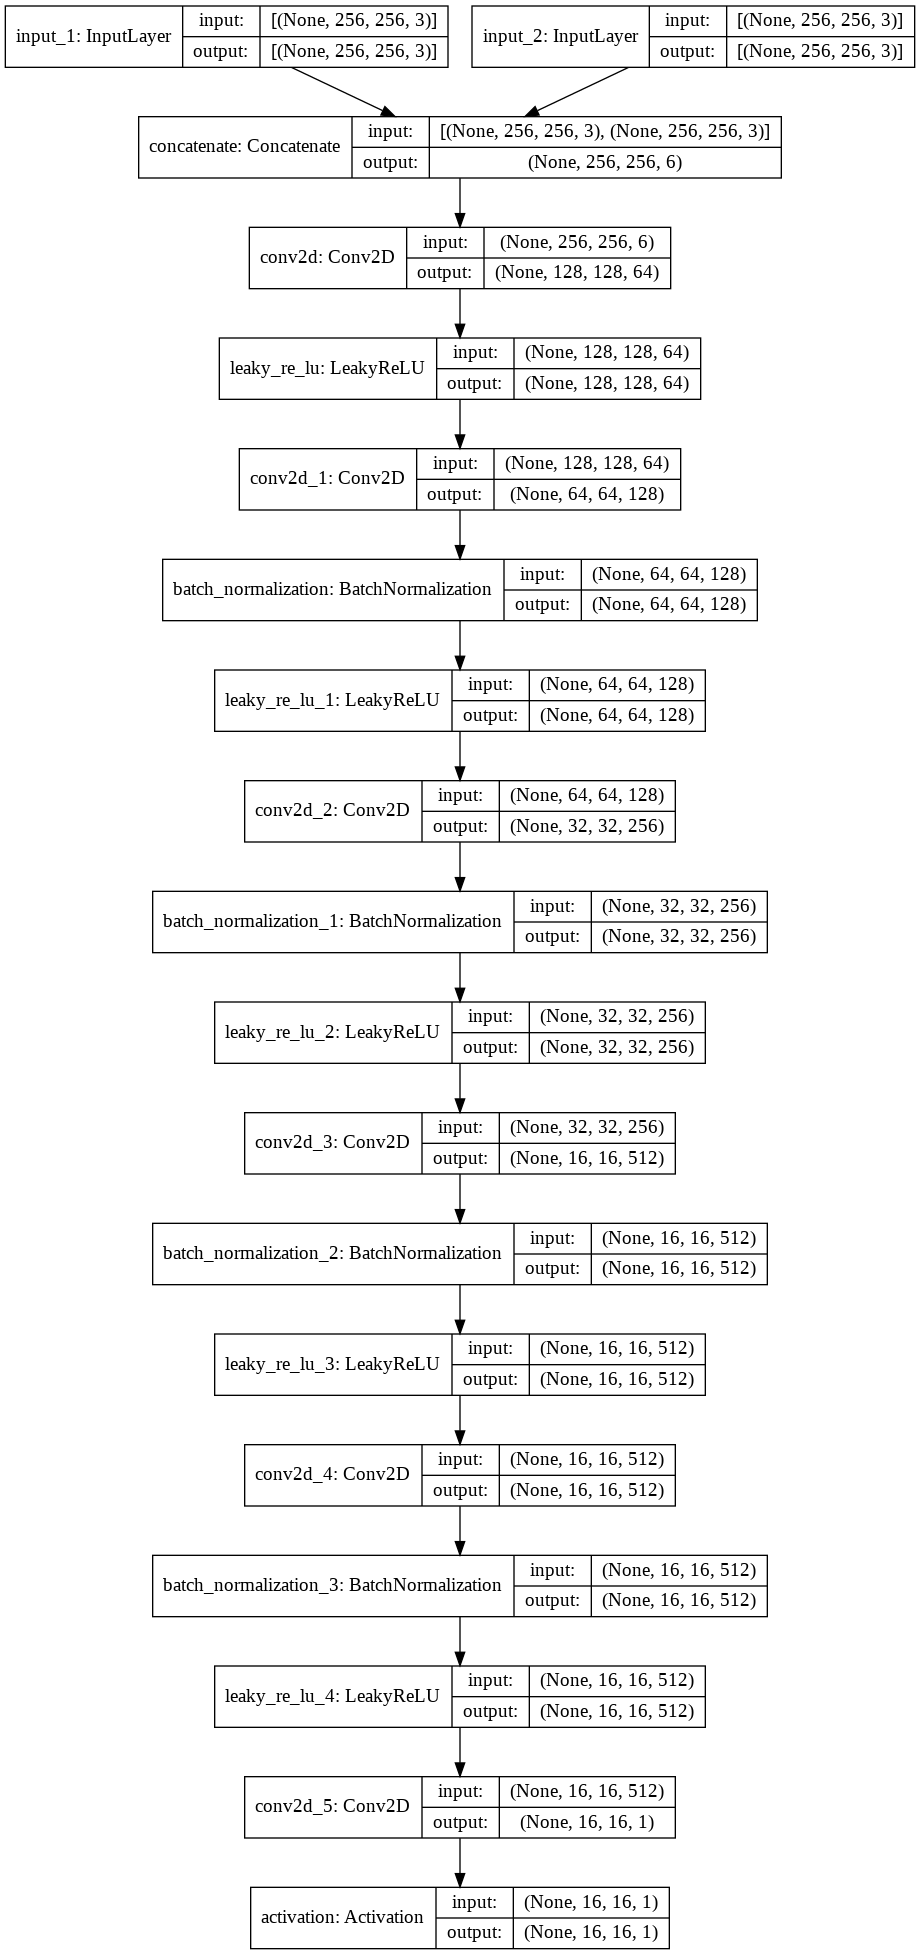

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization using kernel_initializer:to initialize the weight matrix in the neural network.
	init = RandomNormal(stddev=0.02)
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)
	merged = Concatenate()([in_src_image, in_target_image])
	d = Conv2D(64,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	
	d = Conv2D(128,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512,(4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1,(4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	opt = Adam(lr=0.0009, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_discriminator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True,
show_layer_names=True)  

Define Helper finction for Generator

In [ ]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
# define a decoder block
def define_decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g


# Define Generator

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 3136        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 128, 128, 64) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 64, 64, 128)  131200      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

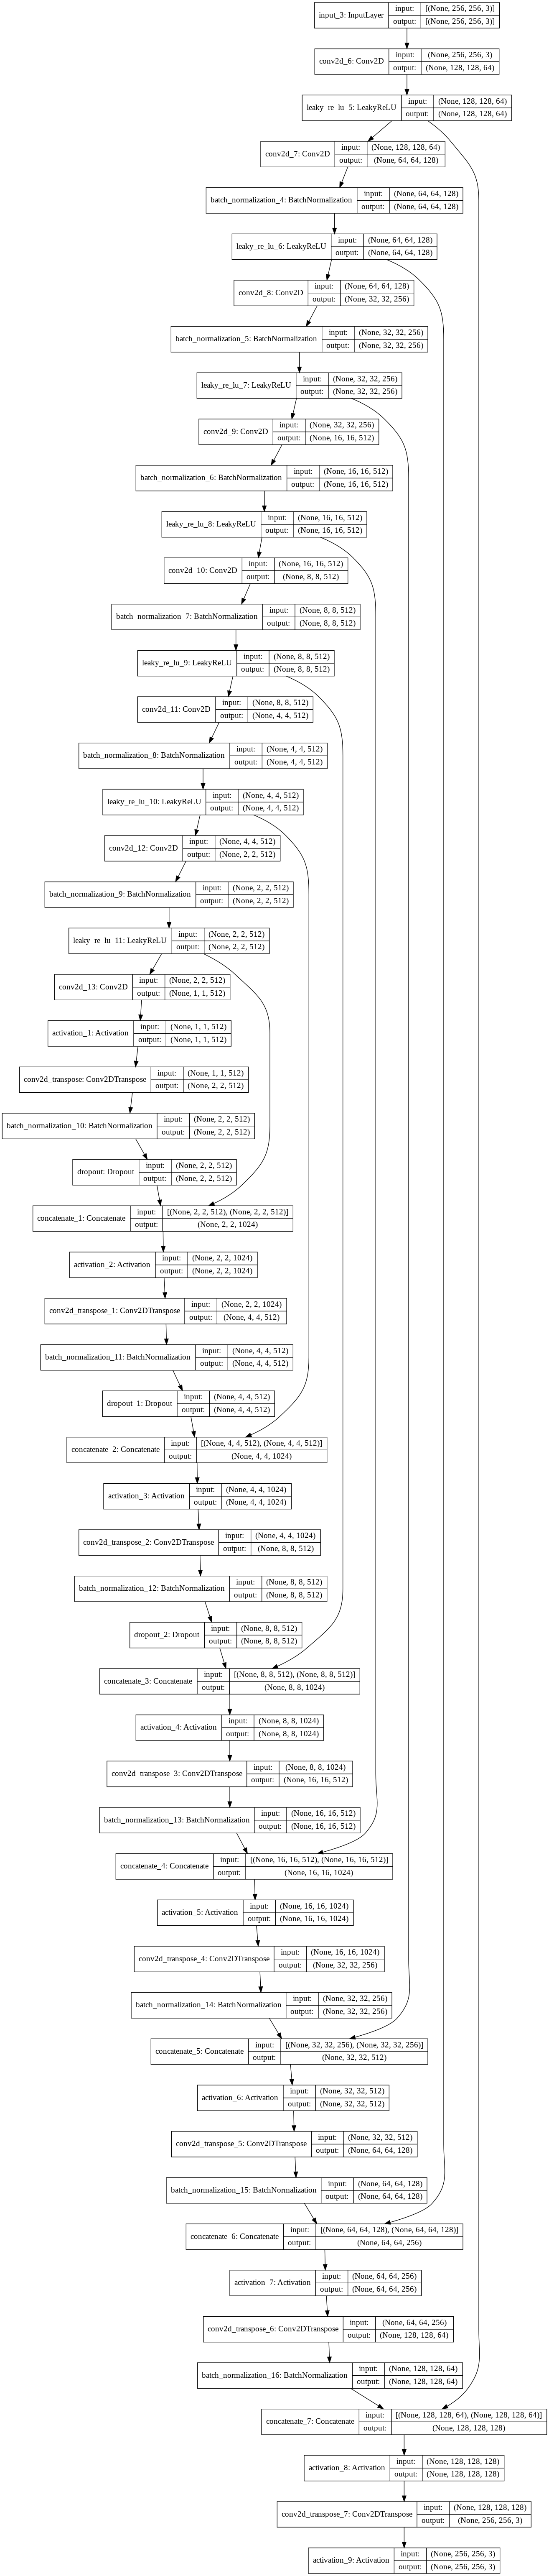

In [ ]:
  
# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = define_decoder_block(b, e7, 512)
	d2 = define_decoder_block(d1, e6, 512)
	d3 = define_decoder_block(d2, e5, 512)
	d4 = define_decoder_block(d3, e4, 512, dropout=False)
	d5 = define_decoder_block(d4, e3, 256, dropout=False)
	d6 = define_decoder_block(d5, e2, 128, dropout=False)
	d7 = define_decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3,(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define image shape
image_shape = (256,256,3)
# create the model
model = define_generator(image_shape)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_model_plot.png', show_shapes=True,
show_layer_names=True) 

# Define GAN

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
  d_model.trainable = False
  in_src = Input(shape=image_shape)
  gen_out = g_model(in_src)
  dis_out = d_model([in_src, gen_out])
  model = Model(in_src, [dis_out, gen_out])
  opt = Adam(lr=0.0009, beta_1=0.5)
  #compile Gan with MAE
  model.compile(loss=['binary_crossentropy','mae'], optimizer=opt, loss_weights=[1,100])
  model.summary()
  plot_model(model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)
  return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]


In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
  X = g_model.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y


In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig('/content/drive/MyDrive/dataset/dataset_project/output/k'+filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save('/content/drive/MyDrive/dataset/dataset_project/output/k'+filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

## Train the model

In [ ]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=30, n_batch=1):
  # determine the output shape of the discriminator
  n_patch = d_model.output_shape[1]
  # unpack dataset
  trainA, trainB = dataset
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    d_loss = 0.5 * np.add(d_loss1, d_loss2)
    # update the generator
    g_loss, _,_= gan_model.train_on_batch(X_realA, [y_real, X_realB])
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
      print('>{}, d_loss:{}, g_loss:{}'.format(i+1, d_loss, g_loss))
      summarize_performance(i,g_model, dataset)

In [ ]:
# load image data
dataset = load_real_samples('/content/drive/MyDrive/dataset/dataset_project/output/maps_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (528, 256, 256, 3) (528, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            (None, 256, 256, 3)  54429315    input_10[0][0]                   
__________________________________________________________________________________________________
model_4 (Functional)            (None, 16, 16, 1)    6968257     input_10[0][0]                   
                                                                 model_5[0][0]                    
Total params: 61,397,572
Trainable params: 54,419,459
Non-trainable params: 6,978,113
____________________________________________________________

## Prediction

In [ ]:
# #predict with single image 
# #load model the one with minimum loss
# for i in range(5):
#   g_model = load_model('/content/drive/MyDrive/dataset/dataset_project/output/model'+str(i+1)+".h5")
#   # load and resize the image
#   img = load_img('/content/drive/MyDrive/dataset/dataset_project/test/sketch/pic19.jpg', target_size=(256, 256))
#   target = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/dataset/dataset_project/test/photo/pic19.jpg'), cv2.COLOR_BGR2RGB)

#   # convert to numpy array
#   img = img_to_array(img)
#   norm_img = (img - 127.5) / 127.5

#   g_img = g_model.predict(np.expand_dims(norm_img, 0))[0]
#   g_img = g_img * 127.5 + 127.5


#   #resize the image back to the original size
#   img = cv2.resize(img, (200, 250))
#   g_img = cv2.resize(g_img, (200, 250))


#   # mae_out = mae_loss(target, g_img)

#   # print("loss ",mae_out)

#   mae_met = mae_metrics(target, g_img)
#   print(mae_met)
#   f = plt.figure(num=None, figsize=(12, 6), dpi=80)
#   ax1 = f.add_subplot(1,3, 1)
#   plt.imshow(img.astype('uint8'))
#   ax2 = f.add_subplot(1,3, 2)
#   plt.imshow(g_img.astype('uint8'))
#   ax3 = f.add_subplot(1,3, 3)
#   plt.imshow(target.astype('uint8'))
#   ax1.set_title('Sketch')
#   ax2.set_title('Generated Image')
#   ax3.set_title('Target Image')

#   plt.show(block=True)


In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

def pred_images(g_model, target_dir, filenames,target, batch_size=1):
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    mae_met=0
    imgs = load_images(filenames)
    target_=load_images(target)
    # target_ = target_ * 127.5 + 127.5

    g_img = g_model.predict(imgs)
    g_img = g_img * 127.5 + 127.5
    for j, _img in enumerate(g_img):
       _img = cv2.resize(_img, (200, 250))
       targett=cv2.resize(cv2.cvtColor(target_[j], cv2.COLOR_RGB2BGR), (200, 250))
       mae=mae_metrics(targett ,_img)
       mae_met+=mae
       cv2.imwrite(target_dir + "/" + os.path.basename(filenames[j]), cv2.resize(cv2.cvtColor(_img.astype('uint8'), cv2.COLOR_RGB2BGR), (200, 250)))
    print("Image has been successfully saved in \"" + target_dir + "\" folder")
    print(mae_met)
    print(mae_met/100)


In [ ]:
filenames = load_filename('/content/drive/MyDrive/dataset/dataset_project/test/sketch/')
target = load_filename('/content/drive/MyDrive/dataset/dataset_project/test/photo/')


In [ ]:
# for i in range(5): model_042240
g_model = load_model('/content/drive/MyDrive/dataset/dataset_project/output/kmodel_010560.h5')

# g_model = load_model('Models/Pixel[1]_Context[0]/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

pred_images(g_model, "/content/drive/MyDrive/dataset/dataset_project/output/kGenerated_images_010560", filenames,target)

Image has been successfully saved in "/content/drive/MyDrive/dataset/dataset_project/output/kGenerated_images_010560" folder
tf.Tensor(15619.921, shape=(), dtype=float32)
tf.Tensor(156.1992, shape=(), dtype=float32)


In [ ]:
# for i in range(5):
g_model = load_model('/content/drive/MyDrive/dataset/dataset_project/output/model2.h5')

# g_model = load_model('Models/Pixel[1]_Context[0]/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

pred_images(g_model, "/content/drive/MyDrive/dataset/dataset_project/output/Generated_images", filenames,target)

In [ ]:
# for i in range(5):
g_model = load_model('/content/drive/MyDrive/dataset/dataset_project/output/model3.h5')

# g_model = load_model('Models/Pixel[1]_Context[0]/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

pred_images(g_model, "/content/drive/MyDrive/dataset/dataset_project/output/Generated_images3", filenames,target)

In [ ]:
# for i in range(5):
g_model = load_model('/content/drive/MyDrive/dataset/dataset_project/output/model4.h5')

# g_model = load_model('Models/Pixel[1]_Context[0]/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

pred_images(g_model, "/content/drive/MyDrive/dataset/dataset_project/output/Generated_images4", filenames,target)

In [ ]:
for i in range(5):
  g_model = load_model('/content/drive/MyDrive/dataset/dataset_project/output/model'+str(i+1)+'.h5')

  # g_model = load_model('Models/Pixel[1]_Context[0]/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

  pred_images(g_model, "/content/drive/MyDrive/dataset/dataset_project/output/Generated_images"+str(i+1), filenames,target)